# 6. Contrastive Fine-tuning


In [1]:
!pip install sentence-transformers transformers[torch] datasets evaluate scikit-learn psutil accelerate sentencepiece --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.7 MB/s eta 0:00:00


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [3]:
import gc
import json
import time
import psutil
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, InputExample, losses, models
from sentence_transformers.evaluation import TripletEvaluator
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix



MODELS_TO_TRAIN = {
    'Ukr-RoBERTa': 'youscan/ukr-roberta-base',
    'mDeBERTa-v3': 'microsoft/mdeberta-v3-base'
}

TRIPLETS_FILE = "datasets/triplets_train.jsonl"
TRAIN_FILE = "datasets/train.jsonl"
TEST_FILE = "datasets/test_mixed_safe.jsonl"

LABEL_MAP = {'safe': 0, 'propaganda': 1, 'harmful': 2}
ID2LABEL = {0: 'safe', 1: 'propaganda', 2: 'harmful'}

In [4]:
train_examples = []
with open(TRIPLETS_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data = json.loads(line)
            train_examples.append(InputExample(texts=[data['anchor'], data['positive'], data['negative']]))
        except: continue
print(f"Loaded {len(train_examples)} triplets.")


import random
random.seed(42)
dev_examples = random.sample(train_examples, k=int(len(train_examples)*0.1))


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    recalls = recall_score(labels, predictions, average=None, zero_division=0)
    return {'accuracy': acc, 'f1_macro': f1}

for model_name, base_model_id in MODELS_TO_TRAIN.items():
    print(f"\n{'='*40}\nPROCESSING MODEL: {model_name}\n{'='*40}")
    
    OUTPUT_Contrastive = f"./results_contrastive_{model_name}"
    OUTPUT_Final = f"./results_classifier_{model_name}"
    
    print("--- Stage 1: Contrastive Pre-training ---")
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
    evaluator = TripletEvaluator.from_input_examples(dev_examples, name='dev-eval')
    
    word_embedding_model = models.Transformer(base_model_id, max_seq_length=512)
    pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
    model_st = SentenceTransformer(modules=[word_embedding_model, pooling_model])
    
    train_loss = losses.MultipleNegativesRankingLoss(model=model_st)
    
    model_st.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=evaluator,
        epochs=10,
        warmup_steps=100,
        optimizer_params={'lr': 1e-5},
        output_path=OUTPUT_Contrastive,
        show_progress_bar=True
    )
    
    del model_st, train_loss, train_dataloader, word_embedding_model, pooling_model, evaluator
    torch.cuda.empty_cache()
    gc.collect()
    
    print("--- Stage 2: Classification Fine-tuning ---")
    
    tokenizer = AutoTokenizer.from_pretrained(OUTPUT_Contrastive)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        
    model = AutoModelForSequenceClassification.from_pretrained(
        OUTPUT_Contrastive, 
        num_labels=3, 
        id2label=ID2LABEL, 
        label2id=LABEL_MAP
    )
    
    dataset = load_dataset('json', data_files={'train': TRAIN_FILE, 'test': TEST_FILE})
    def preprocess(examples):
        return tokenizer(examples['prompt'], truncation=True, padding=False, max_length=512)
    
    encoded = dataset.map(preprocess, batched=True)
    encoded['train'] = encoded['train'].map(lambda x: {'label': LABEL_MAP[x['tag']]})
    encoded['test'] = encoded['test'].map(lambda x: {'label': LABEL_MAP[x['tag']]})
    collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    training_args = TrainingArguments(
        output_dir=OUTPUT_Final,
        learning_rate=5e-6,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        save_only_model=True, 
        load_best_model_at_end=True,
        report_to="none",
        fp16=torch.cuda.is_available()
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded['train'],
        eval_dataset=encoded['test'],
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )
    
    trainer.train()
    trainer.save_model(OUTPUT_Final)
    print(f"Final Model saved to {OUTPUT_Final}")
    
    del model, trainer, tokenizer
    torch.cuda.empty_cache()
    gc.collect()

Loaded 1998 triplets.

PROCESSING MODEL: Ukr-RoBERTa
--- Stage 1: Contrastive Pre-training ---


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/507M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/507M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Dev-eval Cosine Accuracy
125,No log,No log,0.844221
250,No log,No log,0.894472
375,No log,No log,0.949749
500,0.548800,No log,0.964824
625,0.548800,No log,0.964824
750,0.548800,No log,0.964824
875,0.548800,No log,0.969849
1000,0.135100,No log,0.969849
1125,0.135100,No log,0.969849
1250,0.135100,No log,0.969849


--- Stage 2: Classification Fine-tuning ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./results_contrastive_Ukr-RoBERTa and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

/tmp/ipython-input-2026611757.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.338269,0.893333,0.891384
2,No log,0.228371,0.938333,0.938127
3,No log,0.414839,0.908333,0.906937
4,0.107800,0.591398,0.895000,0.892824
5,0.107800,0.586819,0.898333,0.896374
6,0.107800,0.649269,0.895000,0.892824
7,0.107800,0.555178,0.905000,0.903430
8,0.010000,0.530078,0.908333,0.906937
9,0.010000,0.632279,0.900000,0.898144
10,0.010000,0.636108,0.900000,0.898144


Final Model saved to ./results_classifier_Ukr-RoBERTa

PROCESSING MODEL: mDeBERTa-v3
--- Stage 1: Contrastive Pre-training ---


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:566: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Dev-eval Cosine Accuracy
125,No log,No log,0.778894
250,No log,No log,0.839196
375,No log,No log,0.879397
500,1.384800,No log,0.899498
625,1.384800,No log,0.914573
750,1.384800,No log,0.929648
875,1.384800,No log,0.939699
1000,0.438800,No log,0.939699
1125,0.438800,No log,0.944724
1250,0.438800,No log,0.944724


--- Stage 2: Classification Fine-tuning ---


The tokenizer you are loading from './results_contrastive_mDeBERTa-v3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at ./results_contrastive_mDeBERTa-v3 and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

/tmp/ipython-input-2026611757.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.322099,0.913333,0.912704
2,No log,0.185965,0.953333,0.953147
3,No log,0.237503,0.941667,0.941561
4,0.197600,0.283194,0.936667,0.936438
5,0.197600,0.393826,0.915000,0.914266
6,0.197600,0.365788,0.918333,0.917703
7,0.197600,0.341396,0.926667,0.926175
8,0.020600,0.332400,0.931667,0.931278
9,0.020600,0.364197,0.925000,0.924470
10,0.020600,0.374019,0.918333,0.917627


Final Model saved to ./results_classifier_mDeBERTa-v3


In [5]:
def visualize_benchmark_results(metrics_df, preds_df, dataset_name="Mixed Test", title_prefix=""):
    print(f"\n{'='*40}\nBENCHMARK RESULTS: {dataset_name}\n{'='*40}")
    
    acc_cols = [c for c in metrics_df.columns if c in ['Model', 'Accuracy', 'F1 (Macro)', 'Recall (Safe)', 'Recall (Propaganda)', 'Recall (Harmful)']]
    res_cols = [c for c in metrics_df.columns if c in ['Model', 'Avg Latency (ms)', 'Peak VRAM (MB)', 'RAM Usage (MB)', 'CPU Usage (%)']]
    
    df_acc = metrics_df[acc_cols]
    df_res = metrics_df[res_cols]
    
    print("\n=== Accuracy Metrics ===")
    display(df_acc.style.background_gradient(cmap='Greens', subset=[c for c in df_acc.columns if c != 'Model']).format(precision=4))
    
    if not df_res.empty and len(df_res.columns) > 1:
        print("\n=== Resource Efficiency Metrics ===")
        display(df_res.style.background_gradient(cmap='Reds', subset=[c for c in df_res.columns if c != 'Model']).format(precision=0))
    
    labels = ['safe', 'propaganda', 'harmful']
    model_cols = [c for c in preds_df.columns if '_pred' in c]
    models = [c.replace('_pred','') for c in model_cols]
    n_models = len(models)
    if n_models == 0: return

    n_cols = 2
    n_rows = (n_models + n_cols - 1) // n_cols 
    color_map = 'Reds' if 'HARD' in dataset_name.upper() else 'Blues'
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6 * n_rows))
    if n_models > 1: axes = axes.flatten()
    else: axes = [axes]
    
    for i, model in enumerate(models):
        y_true = preds_df['true_label']
        y_pred = preds_df[f'{model}_pred']
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, ax=axes[i], cmap=color_map)
        
        full_title = f"[{title_prefix}] {model} | {dataset_name}" if title_prefix else f"{model} | {dataset_name}"
        axes[i].set_title(full_title, fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    for i in range(n_models, len(axes)): fig.delaxes(axes[i])
    plt.tight_layout()
    plt.show()


def run_benchmark_on_dataset(dataset_path, dataset_name):
    print(f"Loading dataset: {dataset_path}...")
    df_raw = pd.read_json(dataset_path, lines=True)
    
    results_summary = []
    detailed_preds = pd.DataFrame({'true_label': df_raw['tag']})
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    for model_name, _ in MODELS_TO_TRAIN.items():
        model_path = f"./results_classifier_{model_name}"
        print(f"Evaluating {model_name} (from {model_path})...")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.reset_peak_memory_stats()
        gc.collect()
        psutil.cpu_percent(interval=None)

        try:
            model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
            tokenizer = AutoTokenizer.from_pretrained(model_path)
        except Exception as e:
            print(f"Error loading {model_name}: {e}")
            continue
            
        latencies = []
        preds = []
        
        model.eval()
        
        for _, row in df_raw.iterrows():
            text = row['prompt']
            start = time.time()
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                pred_id = torch.argmax(outputs.logits, dim=-1).item()
            latencies.append((time.time() - start) * 1000)
            preds.append(ID2LABEL[pred_id])
            
        detailed_preds[f'{model_name}_pred'] = preds
        
        valid_labels = ['safe', 'propaganda', 'harmful']
        acc = accuracy_score(detailed_preds['true_label'], preds)
        f1 = f1_score(detailed_preds['true_label'], preds, average='macro', zero_division=0)
        recalls = recall_score(detailed_preds['true_label'], preds, labels=valid_labels, average=None, zero_division=0)
        
        peak_vram = torch.cuda.max_memory_allocated() / 1024 / 1024 if torch.cuda.is_available() else 0
        ram_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
        cpu_usage = psutil.cpu_percent(interval=None)
        
        results_summary.append({
            'Model': f"Contrastive-{model_name}",
            'Accuracy': acc,
            'F1 (Macro)': f1,
            'Recall (Safe)': recalls[0],
            'Recall (Propaganda)': recalls[1],
            'Recall (Harmful)': recalls[2],
            'Avg Latency (ms)': np.mean(latencies),
            'Peak VRAM (MB)': peak_vram,
            'RAM Usage (MB)': ram_usage,
            'CPU Usage (%)': cpu_usage
        })
        
        del model, tokenizer
        
    return pd.DataFrame(results_summary), detailed_preds

Loading dataset: datasets/test_mixed_safe.jsonl...
Evaluating Ukr-RoBERTa (from ./results_classifier_Ukr-RoBERTa)...
Evaluating mDeBERTa-v3 (from ./results_classifier_mDeBERTa-v3)...


The tokenizer you are loading from './results_classifier_mDeBERTa-v3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



BENCHMARK RESULTS: SIMPLE Test

=== Accuracy Metrics ===


,Model,Accuracy,F1 (Macro),Recall (Safe),Recall (Propaganda),Recall (Harmful)
0,Contrastive-Ukr-RoBERTa,0.9383,0.9381,0.8550,1.0000,0.9600
1,Contrastive-mDeBERTa-v3,0.9533,0.9531,0.9250,1.0000,0.9350



=== Resource Efficiency Metrics ===


,Model,Avg Latency (ms),Peak VRAM (MB),RAM Usage (MB),CPU Usage (%)
0,Contrastive-Ukr-RoBERTa,9,510,3606,9
1,Contrastive-mDeBERTa-v3,23,1115,3607,10


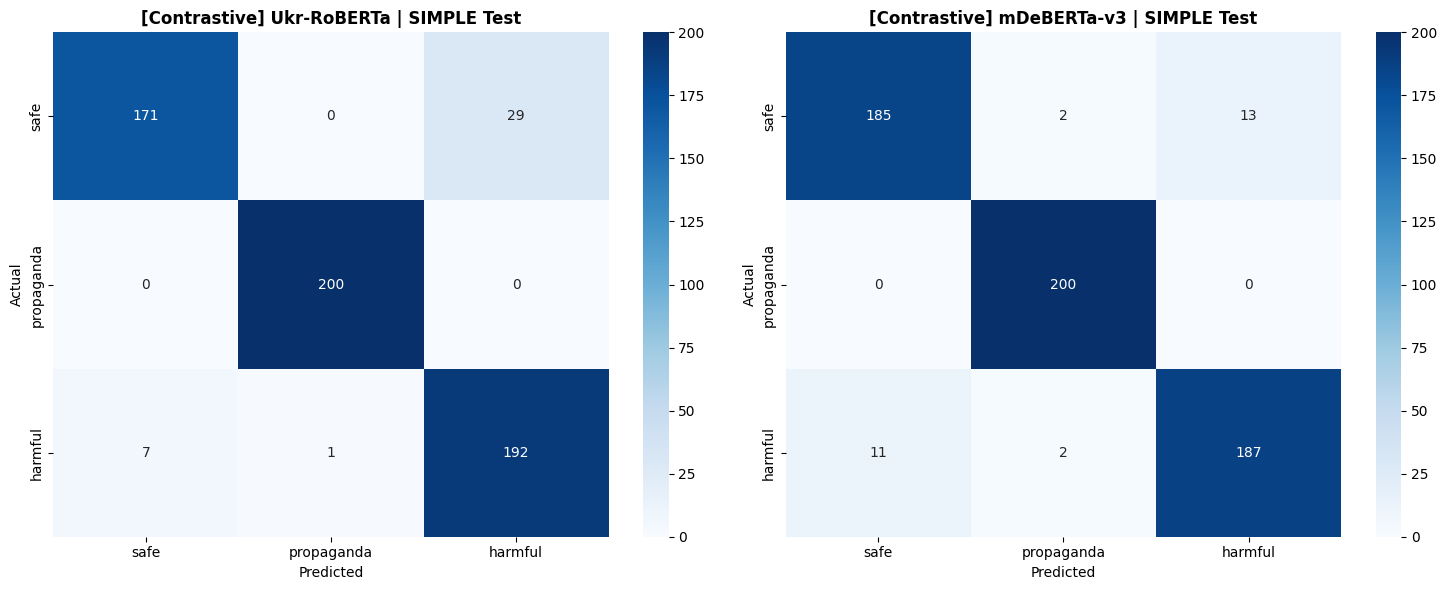

Loading dataset: datasets/hard_test.jsonl...
Evaluating Ukr-RoBERTa (from ./results_classifier_Ukr-RoBERTa)...
Evaluating mDeBERTa-v3 (from ./results_classifier_mDeBERTa-v3)...


The tokenizer you are loading from './results_classifier_mDeBERTa-v3' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



BENCHMARK RESULTS: HARD Test

=== Accuracy Metrics ===


,Model,Accuracy,F1 (Macro),Recall (Safe),Recall (Propaganda),Recall (Harmful)
0,Contrastive-Ukr-RoBERTa,0.9151,0.9151,0.9900,0.8927,0.8600
1,Contrastive-mDeBERTa-v3,0.9116,0.9123,0.9700,0.9153,0.8500



=== Resource Efficiency Metrics ===


,Model,Avg Latency (ms),Peak VRAM (MB),RAM Usage (MB),CPU Usage (%)
0,Contrastive-Ukr-RoBERTa,8,501,3608,10
1,Contrastive-mDeBERTa-v3,23,1095,3608,10


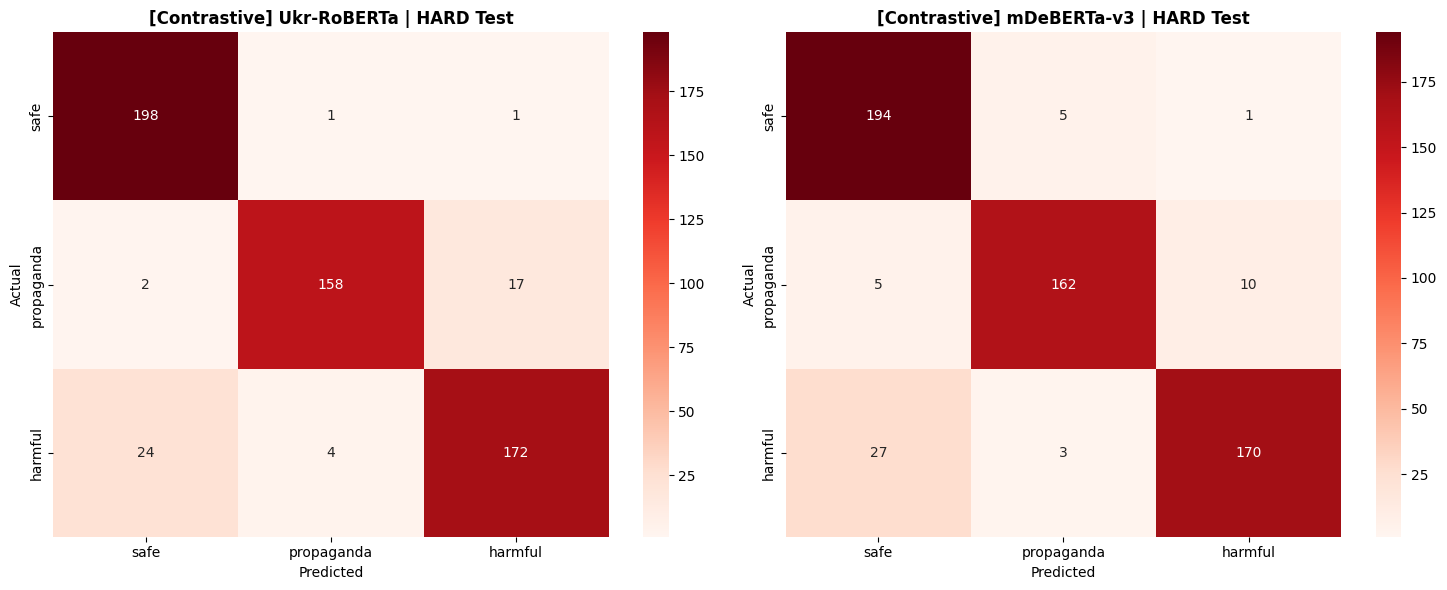

In [6]:
DATASETS_TO_TEST = [
    ("datasets/test_mixed_safe.jsonl", "SIMPLE Test"),
    ("datasets/hard_test.jsonl", "HARD Test"),
]


for path, name in DATASETS_TO_TEST:
    if os.path.exists(path):
        metrics, preds = run_benchmark_on_dataset(path, name)
        visualize_benchmark_results(metrics, preds, dataset_name=name, title_prefix="Contrastive")
    else:
        print(f"Warning: Dataset {path} not found. Skipping.")